In [5]:
import mido
from mido import Message, MidiFile, MidiTrack,MetaMessage
import string
import numpy as np
import pandas as pd
from midi_arr import *
from demo.midi_array import *
import os
import csv
import matplotlib.pyplot as plt


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Load data

In [7]:
# # label path     
# label_path = r'D:\BrownUniversity\CS2470\final_proj\CS2470_final\data\label.csv'
# # Define the folder path
# folder_path = r'D:\BrownUniversity\CS2470\final_proj\CS2470_final\data\test'
# # load data
# music,label, align_length = get_music_data(folder_path, label_path)

In [8]:
music = load_music()
label = load_label()

In [30]:
print(len(music))
print(music[10].shape)


1078
torch.Size([500, 3])


In [140]:
def convert_reco(reconstruction):
    # note
    notes = reconstruction[:, ::3] 
    notes = torch.sigmoid(notes)
    notes = (notes * (108 - 21)) + 21
    # velocity 
    velocity = reconstruction[:, 1::3]  
    velocity = torch.sigmoid(velocity)
    velocity = (velocity * (127 - 0)) + 0

    time = reconstruction[:, 2::3] 
    time = torch.sigmoid(time)
    time = (time * (350 - 0)) + 0

    return notes,velocity,time

def comb_reco(notes,velocity,time):
    stacked_tensor = torch.stack((notes, velocity, time), dim=1)
    stacked_tensor = stacked_tensor.squeeze()
    reconstruction = stacked_tensor.t().flatten()
    return reconstruction

In [154]:
def min_max_normalize(tensor, min_value, max_value):
    min_val = tensor.min()
    max_val = tensor.max()
    normalized_tensor = min_value + (tensor - min_val) * (max_value - min_value) / (max_val - min_val)
    return normalized_tensor

def convert_loss(reconstruction):
    # note
    notes = reconstruction[::3] 
    notes = min_max_normalize(notes,21,108)
    # velocity 
    velocity = reconstruction[1::3]  
    velocity = min_max_normalize(notes,0,127)
    # time
    time = reconstruction[2::3] 
    time = min_max_normalize(notes,0,300)

    return notes,velocity,time

def comb_loss(notes,velocity,time):
    stacked_tensor = torch.stack((notes, velocity, time), dim=1)
    # stacked_tensor = stacked_tensor.squeeze()
    # reconstruction = stacked_tensor.t().flatten()
    reconstruction = stacked_tensor.reshape(-1)
    return reconstruction

## CVAE

In [181]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, dropout_prob=0.5):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size , hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3_mean = nn.Linear(hidden_size, latent_size)
        self.fc3_logvar = nn.Linear(hidden_size, latent_size)
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        mean = self.fc3_mean(x)
        mean = torch.sigmoid(mean)
        mean = (mean * (127 - 0)) + 0

        logvar = self.fc3_logvar(x)
        logvar = torch.sigmoid(logvar)
        logvar = (logvar * (127 - 0)) + 0

        return mean, logvar

class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3_n = nn.Linear(84, 500)
        self.fc3_v = nn.Linear(84, 500)
        self.fc3_t = nn.Linear(84, 500)
        # self.fc4 = nn.Linear(hidden_size, output_size)
        
    def forward(self, z):
        # Concatenate latent variable with class information
        z = F.relu(self.fc1(z))
        reconstruction = self.fc2(z)  
        print(f"reconstruction:{reconstruction}")
        # Convert reconstruction 
        note,velocity,time = convert_reco(reconstruction)
        note = F.relu(self.fc3_n(note))
        velocity = F.relu(self.fc3_v(velocity))
        time = F.relu(self.fc3_t(time))
        reconstruction = comb_reco(note,velocity,time)

        return reconstruction

class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, output_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size, hidden_size, output_size)
        
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        x = x.to(torch.float32)
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z)

        return reconstruction, mean, logvar



In [182]:
# # TODO change shape
input_size = 500 * 3
hidden_size = 252
output_size = 500 * 3
latent_size = 32
vae_model = VAE(input_size, hidden_size, latent_size, output_size)

In [183]:
# optimizer
learning_rate = 0.05
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)
# loss function
def melody_loss(predicted_notes, target_notes):
    return nn.CrossEntropyLoss()(predicted_notes, target_notes)

def harmony_loss(predicted_chords, target_chords):
    return nn.CrossEntropyLoss()(predicted_chords, target_chords)

def rhythm_loss(predicted_times, target_times):
    return nn.MSELoss()(predicted_times, target_times)

def hierarchical_music_loss(predicted_music, target_music):
    # print(f"music_shape:{predicted_music.shape}")
    # print(f"target_music:{target_music.shape}")    
    target_music = target_music.squeeze()
    # Extract different components of the music (e.g., notes, velocities, times)
    predicted_notes, predicted_velocities, predicted_times = convert_loss(predicted_music)
    target_notes, target_velocities, target_times = convert_loss(target_music)

    # each music component loss 
    # print(f"predicted_notes:{predicted_notes.shape}")
    # print(f"target_notes:{target_notes.shape}")
    melody_loss_value = melody_loss(predicted_notes, target_notes)
    harmony_loss_value = harmony_loss(predicted_velocities, target_velocities)
    rhythm_loss_value = rhythm_loss(predicted_times, target_times)

    # Combine individual losses
    total_loss = melody_loss_value + harmony_loss_value + rhythm_loss_value

    return total_loss

In [184]:

# # Define optimizer
# learning_rate = 0.05
# optimizer = optim.Adam(cvae_model.parameters(), lr=learning_rate)

# Define loss function
def loss_function(recon_x, x, mu, logvar):
    x = x.squeeze()
    CE = nn.CrossEntropyLoss(reduction='sum')  # Cross-entropy loss
    reconstruction_loss = CE(recon_x, x.view(-1, input_size))
    # reconstruction_loss = CE(recon_x, x)
    # music_loss = hierarchical_music_loss(recon_x, x.view(-1, input_size))
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reconstruction_loss + KLD 

# Define your training function
def train(epoch, train_loader, log_interval):
    vae_model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.view(-1, input_size).to(torch.float32)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae_model(data)

        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))



In [185]:
# Assuming you have defined train_loader (your data loader for training data)

# label = torch.tensor(labels)
# music = torch.tensor(music)

# data
# dataset = TensorDataset(music)
dataloader = DataLoader(music, shuffle=True)

# Set number of epochs and log interval
num_epochs = 15
log_interval = 10

# Train the model
for epoch in range(num_epochs):
        train(epoch,dataloader,log_interval)

reconstruction:tensor([[-1.9081e+27, -3.2346e+26, -9.3402e+26, -1.1296e+27,  1.8928e+27,
         -2.5787e+26,  6.3911e+25, -6.2162e+26,  5.9838e+26,  2.0386e+26,
         -4.0179e+26, -9.9139e+26,  9.2414e+26, -1.2174e+27,  3.1483e+26,
         -1.7127e+27,  1.4938e+27, -2.3775e+26,  1.2314e+27, -2.8980e+26,
          8.3554e+26, -1.0867e+27,  5.0024e+26,  5.5470e+26,  3.8482e+26,
          1.3357e+25,  1.3066e+27,  1.8178e+27, -8.6576e+26,  1.6666e+26,
          7.2928e+26,  7.2556e+26, -1.3276e+27,  7.6171e+25, -1.8794e+27,
          3.9256e+26,  2.1341e+26,  5.5036e+26,  3.7040e+26, -2.8332e+26,
         -1.8244e+26,  4.1373e+26,  2.8266e+26, -2.5140e+26,  2.0322e+27,
          5.6302e+26, -1.8777e+26, -1.5052e+27,  5.0220e+26, -7.2692e+26,
          5.8989e+24,  4.9162e+26, -1.5810e+26, -8.4954e+26,  8.4944e+26,
          1.2221e+27,  1.3109e+27, -7.6833e+26, -3.9151e+25,  2.4171e+26,
         -1.6850e+26, -6.8124e+26,  1.7856e+25, -5.8553e+26, -1.8337e+25,
          7.9721e+26, -

KeyboardInterrupt: 

In [19]:
print(f"label_shape:{label.shape}") 
print(f"musci_shape:{music.shape}") 

label_shape:torch.Size([1078, 4])
musci_shape:torch.Size([1078, 500, 3])


In [49]:
# Assuming you have a trained decoder model
# TODO change outputshape
decoder = Decoder(latent_size=4, hidden_size=256, output_size= 500 * 3, num_classes=4)

# Sample from the latent space (you can use any method to sample from a distribution, such as normal distribution)
latent_sample = torch.randn(1, 4)*2  # Assuming batch size of 1

target_label = [0,0,0,1]
target_label_tensor = torch.tensor(target_label, dtype=torch.float32).unsqueeze(0)
# Pass the sampled latent vectors through the decoder
with torch.no_grad():
    generated_data = decoder(latent_sample,target_label_tensor)

# The generated_data tensor contains the generated data points
generated_data = generated_data.round().int()
generated_data = generated_data.reshape(500 , 3) # TODO change outputshape 
generated_data = generated_data.tolist()
print(generated_data)

[[53, 57, 62], [57, 64, 62], [63, 57, 58], [65, 61, 63], [73, 67, 54], [61, 51, 57], [60, 58, 65], [54, 50, 65], [55, 61, 64], [62, 60, 63], [58, 62, 74], [56, 58, 69], [52, 63, 61], [56, 58, 51], [55, 58, 52], [52, 58, 68], [65, 57, 56], [63, 54, 56], [66, 63, 59], [67, 56, 61], [59, 66, 65], [59, 55, 65], [55, 59, 59], [66, 54, 65], [61, 65, 63], [65, 56, 61], [56, 61, 62], [56, 53, 59], [53, 56, 66], [54, 61, 57], [60, 49, 55], [56, 72, 56], [63, 63, 61], [65, 65, 63], [57, 57, 65], [56, 54, 60], [63, 64, 70], [56, 61, 55], [55, 53, 57], [65, 61, 63], [58, 60, 59], [60, 60, 66], [59, 60, 53], [60, 59, 53], [52, 66, 65], [68, 63, 62], [55, 59, 62], [57, 60, 56], [63, 57, 62], [69, 61, 65], [60, 67, 62], [61, 51, 58], [55, 65, 60], [54, 62, 58], [59, 60, 65], [62, 61, 63], [56, 63, 64], [63, 62, 64], [53, 65, 53], [51, 65, 60], [54, 56, 56], [60, 62, 61], [58, 65, 59], [58, 66, 55], [58, 59, 64], [59, 51, 56], [62, 56, 60], [58, 63, 60], [62, 59, 62], [50, 67, 66], [63, 62, 59], [63, 

In [21]:
print(len(generated_data))

500


In [29]:
def midi_music(events, output_file):
    mid = mido.MidiFile()

    # Create track for metadata (track 0)
    metadata_track = mido.MidiTrack()
    mid.tracks.append(metadata_track)

    # Set the tempo to default 120 BPM in track 0
    metadata_track.append(mido.MetaMessage('set_tempo', tempo=500000))

    # Create track for music data (track 1)
    music_track = mido.MidiTrack()
    mid.tracks.append(music_track)

    # Iterate through the events and convert them to MIDI messages for track 1
    for event in events:
        note, velocity, time = event
        if note == 0 and velocity == 0 and time == 0:
            break
        # Create a note_on message for track 1
        note_on = mido.Message('note_on', note=note, velocity=velocity, time=time)
        music_track.append(note_on)

    # Save the MIDI file
    mid.save(output_file)


In [30]:
# MIDI events / list format
events = generated_data

# Output MIDI file name
output_file = "output_label2.mid"

# Reconstruct MIDI and save to file
midi_music(events, output_file)

In [28]:
# Load the MIDI file
path = r"D:\BrownUniversity\CS2470\final_proj\CS2470_final_project\data\EMOPIA\midis\Q1__8v0MFBZoco_0.mid"
mid = mido.MidiFile(path)

# Iterate over all messages in all tracks
for i, track in enumerate(mid.tracks):
    print(f'Track {i}: {track.name}')
    for msg in track:
        print(msg)

Track 0: 
MetaMessage('set_tempo', tempo=500000, time=0)
MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('end_of_track', time=1)
Track 1: 
note_on channel=0 note=52 velocity=89 time=305
note_on channel=0 note=64 velocity=90 time=2
note_on channel=0 note=52 velocity=0 time=63
note_on channel=0 note=64 velocity=0 time=2
note_on channel=0 note=58 velocity=91 time=118
note_on channel=0 note=70 velocity=83 time=2
note_on channel=0 note=58 velocity=0 time=69
note_on channel=0 note=70 velocity=0 time=25
note_on channel=0 note=59 velocity=86 time=2
note_on channel=0 note=71 velocity=78 time=0
note_on channel=0 note=62 velocity=88 time=99
note_on channel=0 note=59 velocity=0 time=0
note_on channel=0 note=74 velocity=80 time=2
note_on channel=0 note=71 velocity=0 time=7
note_on channel=0 note=78 velocity=86 time=98
note_on channel=0 note=66 velocity=86 time=1
note_on channel=0 note=62 velocity=0 time=19
note_on cha

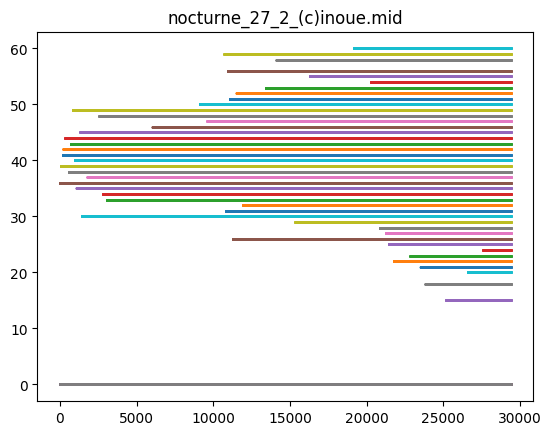

In [37]:
mmid = mido.MidiFile('output_label2.mid')
result_array = mid2arry(mmid)

plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("nocturne_27_2_(c)inoue.mid")
plt.show()